In [23]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

from keras import layers
from keras import Model, Input

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

%matplotlib inline

In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/np.zip' -d '/content/'
!unzip '/content/drive/My Drive/main.zip' -d '/content/'
'''


"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n!unzip '/content/drive/My Drive/np.zip' -d '/content/'\n!unzip '/content/drive/My Drive/main.zip' -d '/content/'\n"

In [4]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = layers.Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

In [5]:
target_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

X_Val = np.load("np/256_192_val.npy")
X_Test = np.load("np/256_192_test.npy")

Y_Val = np.load("np/val_labels.npy")
Y_Test = np.load("np/test_labels.npy")

X_Train = np.load("np/256_192_train.npy")
Y_Train = np.load("np/train_labels.npy")

Y_Val = to_categorical(Y_Val)
Y_Test = to_categorical(Y_Test)
Y_Train = to_categorical(Y_Train)

In [6]:
print('X_Train : ', X_Train.shape)
print('Y_Train : ', Y_Train.shape)

print('X_Test : ', X_Test.shape)
print('Y_Test : ', Y_Test.shape)

print('X_Val : ', X_Val.shape)
print('Y_Val : ', Y_Val.shape)

X_Train :  (8111, 192, 256, 3)
Y_Train :  (8111, 7)
X_Test :  (1002, 192, 256, 3)
Y_Test :  (1002, 7)
X_Val :  (902, 192, 256, 3)
Y_Val :  (902, 7)


In [7]:
input_shape = X_Val[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [9]:
# INCEPTION v3

'''
inception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

for layer in inception.layers:
    layer.trainable = True
    
inception_last_layer = inception.get_layer('mixed10')
print('last layer output shape:', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

x_inception = layers.GlobalMaxPooling2D()(inception_last_output)
x_inception = layers.Dense(512, activation='relu')(x_inception)
x_inception = layers.Dropout(0.5)(x_inception)
x_inception = layers.Dense(7, activation='softmax')(x_inception)

# Configure and compile the model

inception_model = Model(model_input, x_inception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
inception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

inception_model.load_weights("Models/main/InceptionV3.h5")
'''

'\ninception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)\n\nfor layer in inception.layers:\n    layer.trainable = True\n    \ninception_last_layer = inception.get_layer(\'mixed10\')\nprint(\'last layer output shape:\', inception_last_layer.output_shape)\ninception_last_output = inception_last_layer.output\n\nx_inception = layers.GlobalMaxPooling2D()(inception_last_output)\nx_inception = layers.Dense(512, activation=\'relu\')(x_inception)\nx_inception = layers.Dropout(0.5)(x_inception)\nx_inception = layers.Dense(7, activation=\'softmax\')(x_inception)\n\n# Configure and compile the model\n\ninception_model = Model(model_input, x_inception)\noptimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)\ninception_model.compile(loss=\'categorical_crossentropy\',\n              optimizer=optimizer,\n              metrics=[\'accuracy\'])\n\ninception_model.load_weights("Models/main/InceptionV3.h5")\n'

In [10]:
# DenseNet 

denseNet = DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

for layer in denseNet.layers:
    layer.trainable = True

denseNet_last_layer = denseNet.get_layer('relu')
print('last layer output shape:', denseNet_last_layer.output_shape)
denseNet_last_output = denseNet_last_layer.output

x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
x_denseNet = layers.Dropout(0.5)(x_denseNet)
x_denseNet = layers.Dense(7, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(model_input, x_denseNet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

denseNet_model.load_weights("Models/main/DenseNet.h5")

last layer output shape: (None, 6, 8, 1920)


              precision    recall  f1-score   support

          nv       0.88      0.54      0.67        28
         mel       0.71      0.91      0.80        57
         bkl       0.59      0.90      0.71       108
         bcc       0.80      0.80      0.80        15
       akiec       0.96      0.91      0.93       678
        vasc       1.00      0.93      0.96        14
          df       0.68      0.52      0.59       102

    accuracy                           0.86      1002
   macro avg       0.80      0.79      0.78      1002
weighted avg       0.87      0.86      0.86      1002



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'DenseNet201 Model'}, xlabel='Predicted', ylabel='Actual'>

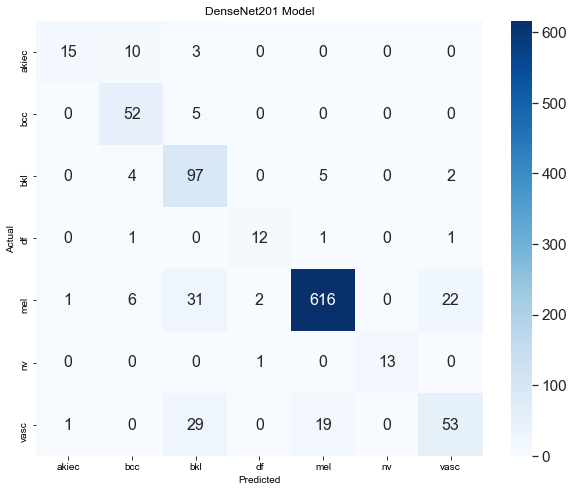

In [11]:
Y_Pred = denseNet_model.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Report = (classification_report(np.argmax(Y_Test, axis=1), Y_Pred, target_names=target_names))
print(Report)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('DenseNet201 Model')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300) 

In [12]:
#VGG16

vgg = VGG16(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

for layer in denseNet.layers:
    layer.trainable = True

vgg_last_layer = vgg.get_layer('block5_pool')
print('last layer output shape:', vgg_last_layer.output_shape)
vgg_last_output = vgg_last_layer.output

x_vgg = layers.GlobalMaxPooling2D()(vgg_last_output)
x_vgg = layers.Dense(512, activation='relu')(x_vgg)
x_vgg = layers.Dropout(0.5)(x_vgg)
x_vgg = layers.Dense(7, activation='softmax')(x_vgg)

# Configure and compile the model

vgg_model = Model(model_input, x_vgg)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

vgg_model.load_weights("Models/main/VGG16.h5")

last layer output shape: (None, 6, 8, 512)


              precision    recall  f1-score   support

          nv       0.71      0.36      0.48        28
         mel       0.85      0.68      0.76        57
         bkl       0.64      0.64      0.64       108
         bcc       0.63      0.80      0.71        15
       akiec       0.90      0.95      0.93       678
        vasc       0.92      0.86      0.89        14
          df       0.70      0.59      0.64       102

    accuracy                           0.85      1002
   macro avg       0.77      0.70      0.72      1002
weighted avg       0.84      0.85      0.84      1002



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'VGG16 Model'}, xlabel='Predicted', ylabel='Actual'>

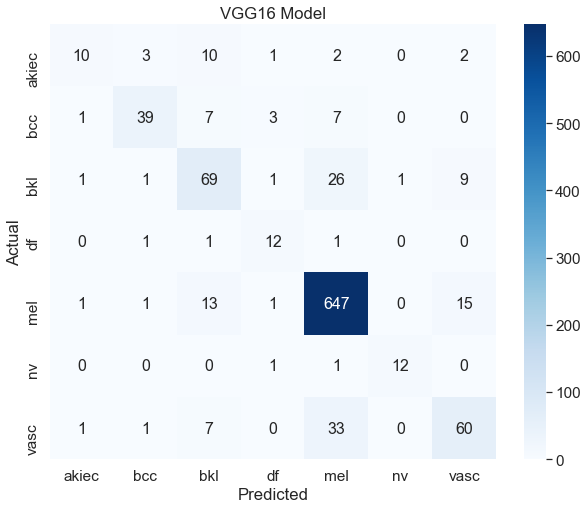

In [13]:
Y_Pred = vgg_model.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Report = (classification_report(np.argmax(Y_Test, axis=1), Y_Pred, target_names=target_names))
print(Report)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('VGG16 Model')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300) 

In [14]:
#ResNet

res = InceptionResNetV2(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

for layer in denseNet.layers:
    layer.trainable = True

res_last_layer = res.get_layer('conv_7b_ac')
print('last layer output shape:', res_last_layer.output_shape)
res_last_output = res_last_layer.output

x_res = layers.GlobalMaxPooling2D()(res_last_output)
x_res = layers.Dense(512, activation='relu')(x_res)
x_res = layers.Dropout(0.5)(x_res)
x_res = layers.Dense(7, activation='softmax')(x_res)

# Configure and compile the model

res_model = Model(model_input, x_res)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

res_model.load_weights("Models/main/InceptionResNet.h5")

last layer output shape: (None, 4, 6, 1536)


              precision    recall  f1-score   support

          nv       0.80      0.43      0.56        28
         mel       0.86      0.75      0.80        57
         bkl       0.67      0.83      0.74       108
         bcc       1.00      0.67      0.80        15
       akiec       0.94      0.95      0.95       678
        vasc       1.00      0.93      0.96        14
          df       0.65      0.63      0.64       102

    accuracy                           0.87      1002
   macro avg       0.85      0.74      0.78      1002
weighted avg       0.88      0.87      0.87      1002



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'InceptionResNetV2 Model'}, xlabel='Predicted', ylabel='Actual'>

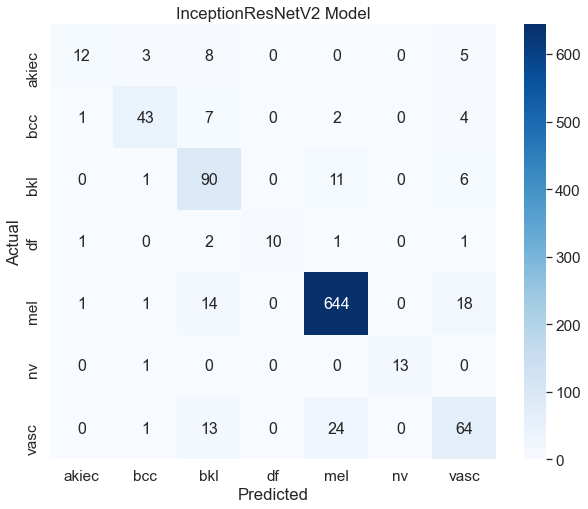

In [15]:
Y_Pred = res_model.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Report = (classification_report(np.argmax(Y_Test, axis=1), Y_Pred, target_names=target_names))
print(Report)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('InceptionResNetV2 Model')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300) 

In [16]:
ensemble_model = ensemble([denseNet_model, vgg_model, res_model], model_input)

In [17]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
___________________________________________________________________________________________

conv5_block20_0_bn (BatchNormal (None, 6, 8, 1504)   6016        conv5_block19_concat[0][0]       
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 4, 6, 192)    399360      block8_3_ac[0][0]                
__________________________________________________________________________________________________
conv5_block20_0_relu (Activatio (None, 6, 8, 1504)   0           conv5_block20_0_bn[0][0]         
__________________________________________________________________________________________________
batch_normalization_176 (BatchN (None, 4, 6, 192)    576         conv2d_176[0][0]                 
__________________________________________________________________________________________________
conv5_block20_1_conv (Conv2D)   (None, 6, 8, 128)    192512      conv5_block20_0_relu[0][0]       
__________________________________________________________________________________________________
activation

In [18]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
loss_train, acc_train = ensemble_model.evaluate(X_Train, Y_Train, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_train, loss_train))

254/254 [==============================] - 1151s 5s/step - loss: 0.0156 - accuracy: 1.0000
Validation: accuracy = 1.000000  ;  loss_v = 0.015617


In [19]:
loss_val, acc_val = ensemble_model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 122s 4s/step - loss: 0.3429 - accuracy: 0.8991
Validation: accuracy = 0.899113  ;  loss_v = 0.342854


In [20]:
loss_test, acc_test = ensemble_model.evaluate(X_Test, Y_Test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 137s 4s/step - loss: 0.3549 - accuracy: 0.8862
Test: accuracy = 0.886228  ;  loss = 0.354933


              precision    recall  f1-score   support

          nv       0.87      0.46      0.60        28
         mel       0.93      0.89      0.91        57
         bkl       0.66      0.84      0.74       108
         bcc       0.92      0.80      0.86        15
       akiec       0.94      0.96      0.95       678
        vasc       1.00      0.86      0.92        14
          df       0.73      0.60      0.66       102

    accuracy                           0.89      1002
   macro avg       0.86      0.77      0.81      1002
weighted avg       0.89      0.89      0.88      1002



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Ensemble Model - Testing Data'}, xlabel='Predicted', ylabel='Actual'>

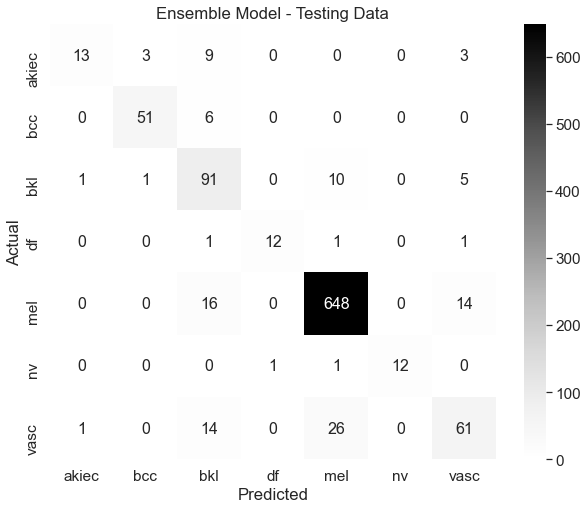

In [21]:
Y_Pred = ensemble_model.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Report = (classification_report(np.argmax(Y_Test, axis=1), Y_Pred, target_names=target_names))
print(Report)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('Ensemble Model - Testing Data')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Greys", annot=True,annot_kws={"size": 16}, fmt='d')

              precision    recall  f1-score   support

          nv       0.89      0.52      0.65        33
         mel       0.89      0.78      0.83        51
         bkl       0.77      0.90      0.83        96
         bcc       0.67      0.67      0.67         9
       akiec       0.95      0.96      0.96       600
        vasc       0.92      0.86      0.89        14
          df       0.74      0.74      0.74        99

    accuracy                           0.90       902
   macro avg       0.83      0.77      0.80       902
weighted avg       0.90      0.90      0.90       902



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Ensemble Model - Validation Data'}, xlabel='Predicted', ylabel='Actual'>

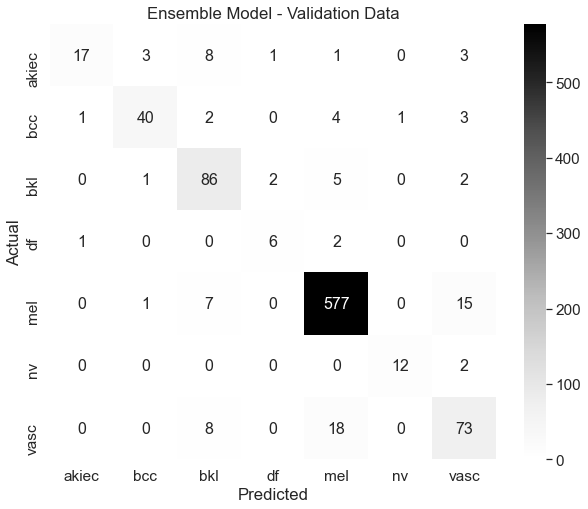

In [22]:
Y_Pred = ensemble_model.predict(X_Val)
Y_Pred = np.argmax(Y_Pred, axis=1)

Report = (classification_report(np.argmax(Y_Val, axis=1), Y_Pred, target_names=target_names))
print(Report)

Matrix = (confusion_matrix(np.argmax(Y_Val, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('Ensemble Model - Validation Data')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Greys", annot=True,annot_kws={"size": 16}, fmt='d')

In [25]:
fpr, tpr, threshold = roc_curve(Y_Val, Y_Test, pos_label = 9)

ValueError: multilabel-indicator format is not supported

{}